# About



# Requirements

If you're running on your local machine or google colab, install these two cells.

I'm running a i9-14900KF and RTX 4080
And for reference this entire notebook takes 45 minutes to process.

In [ ]:
!pip install -U ipywidgets

In [ ]:
!pip install pandas==2.2.2 numpy==1.26.4 scikit-learn==1.2.2 xgboost==2.0.3 matplotlib==3.7.5 seaborn==0.12.2 shap==0.44.1 scikit-optimize==0.10.2

If you're running this on Kaggle.... Don't need to install anything


# Importing in Libraries

In [ ]:
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import OneHotEncoder
from sklearn.compose import ColumnTransformer
from sklearn.impute import SimpleImputer
from sklearn.pipeline import Pipeline
from sklearn.metrics import mean_absolute_error, cohen_kappa_score, confusion_matrix
from sklearn.metrics import (accuracy_score, f1_score, precision_score,
                             recall_score, classification_report)
from sklearn.metrics import roc_curve, auc, ConfusionMatrixDisplay
from sklearn.preprocessing import StandardScaler
import matplotlib.pyplot as plt
import seaborn as sns
import shap


from sklearn.ensemble import RandomForestClassifier
from sklearn.neighbors import KNeighborsClassifier
import xgboost as xgb
from sklearn.ensemble import GradientBoostingClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.svm import SVC

# Loading Data

In [ ]:
# Load data
dataset_path = 'diamonds.csv'
df = pd.read_csv(dataset_path)

In [ ]:
df.head()

,Unnamed: 0,carat,cut,color,clarity,depth,table,price,x,y,z
0,1,0.23,Ideal,E,SI2,61.5,55.0,326,3.95,3.98,2.43
1,2,0.21,Premium,E,SI1,59.8,61.0,326,3.89,3.84,2.31
2,3,0.23,Good,E,VS1,56.9,65.0,327,4.05,4.07,2.31
3,4,0.29,Premium,I,VS2,62.4,58.0,334,4.20,4.23,2.63
4,5,0.31,Good,J,SI2,63.3,58.0,335,4.34,4.35,2.75


# Preprocessing

In [ ]:
# Data cleaning
df = df.drop('Unnamed: 0', axis=1)

# Handle zero values in dimensions
df[['x', 'y', 'z']] = df[['x', 'y', 'z']].replace(0, np.nan)
df = df.dropna()

# Feature Engineering
**Ordinal Encoding of Cut Quality**: The diamond dataset contains a categorical feature 'cut' with different quality levels. To prepare this feature, we need to convert these categorical labels into a numerical format. (0-4)

**Cut Quality Hierarchy**: We define a hierarchical order of cut quality from lowest to highest:

* 0 = Fair (lowest quality)
* 1 = Good
* 2 = Very Good
* 3 = Premium
* 4 = Ideal (highest quality)

**Volume Calculation**: We introduce a new feature 'volume' by multiplying the diamond's x, y, and z dimensions. This provides insights into the diamond's overall size, which can be a meaningful predictor of price.

**Density Calculation**: We compute diamond density by dividing carat weight by volume. This new feature can reveal interesting characteristics about the diamond's composition.



In [ ]:
# Define ordinal mapping for cut
cut_order = ['Fair', 'Good', 'Very Good', 'Premium', 'Ideal']
df['cut'] = df['cut'].map({v: k for k, v in enumerate(cut_order)}).astype(int)

# Feature engineering with safety checks
df['volume'] = df['x'] * df['y'] * df['z']
df['density'] = df['carat'] / (df['volume'] + 1e-6)  # Add small epsilon to avoid division by zero

# Remove infinite values and NaNs
df = df.replace([np.inf, -np.inf], np.nan).dropna()

In [ ]:
df.head()

,carat,cut,color,clarity,depth,table,price,x,y,z,volume,density
0,0.23,4,E,SI2,61.5,55.0,326,3.95,3.98,2.43,38.202030,0.006021
1,0.21,3,E,SI1,59.8,61.0,326,3.89,3.84,2.31,34.505856,0.006086
2,0.23,1,E,VS1,56.9,65.0,327,4.05,4.07,2.31,38.076885,0.006040
3,0.29,3,I,VS2,62.4,58.0,334,4.20,4.23,2.63,46.724580,0.006207
4,0.31,1,J,SI2,63.3,58.0,335,4.34,4.35,2.75,51.917250,0.005971


# Visualizations

use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.


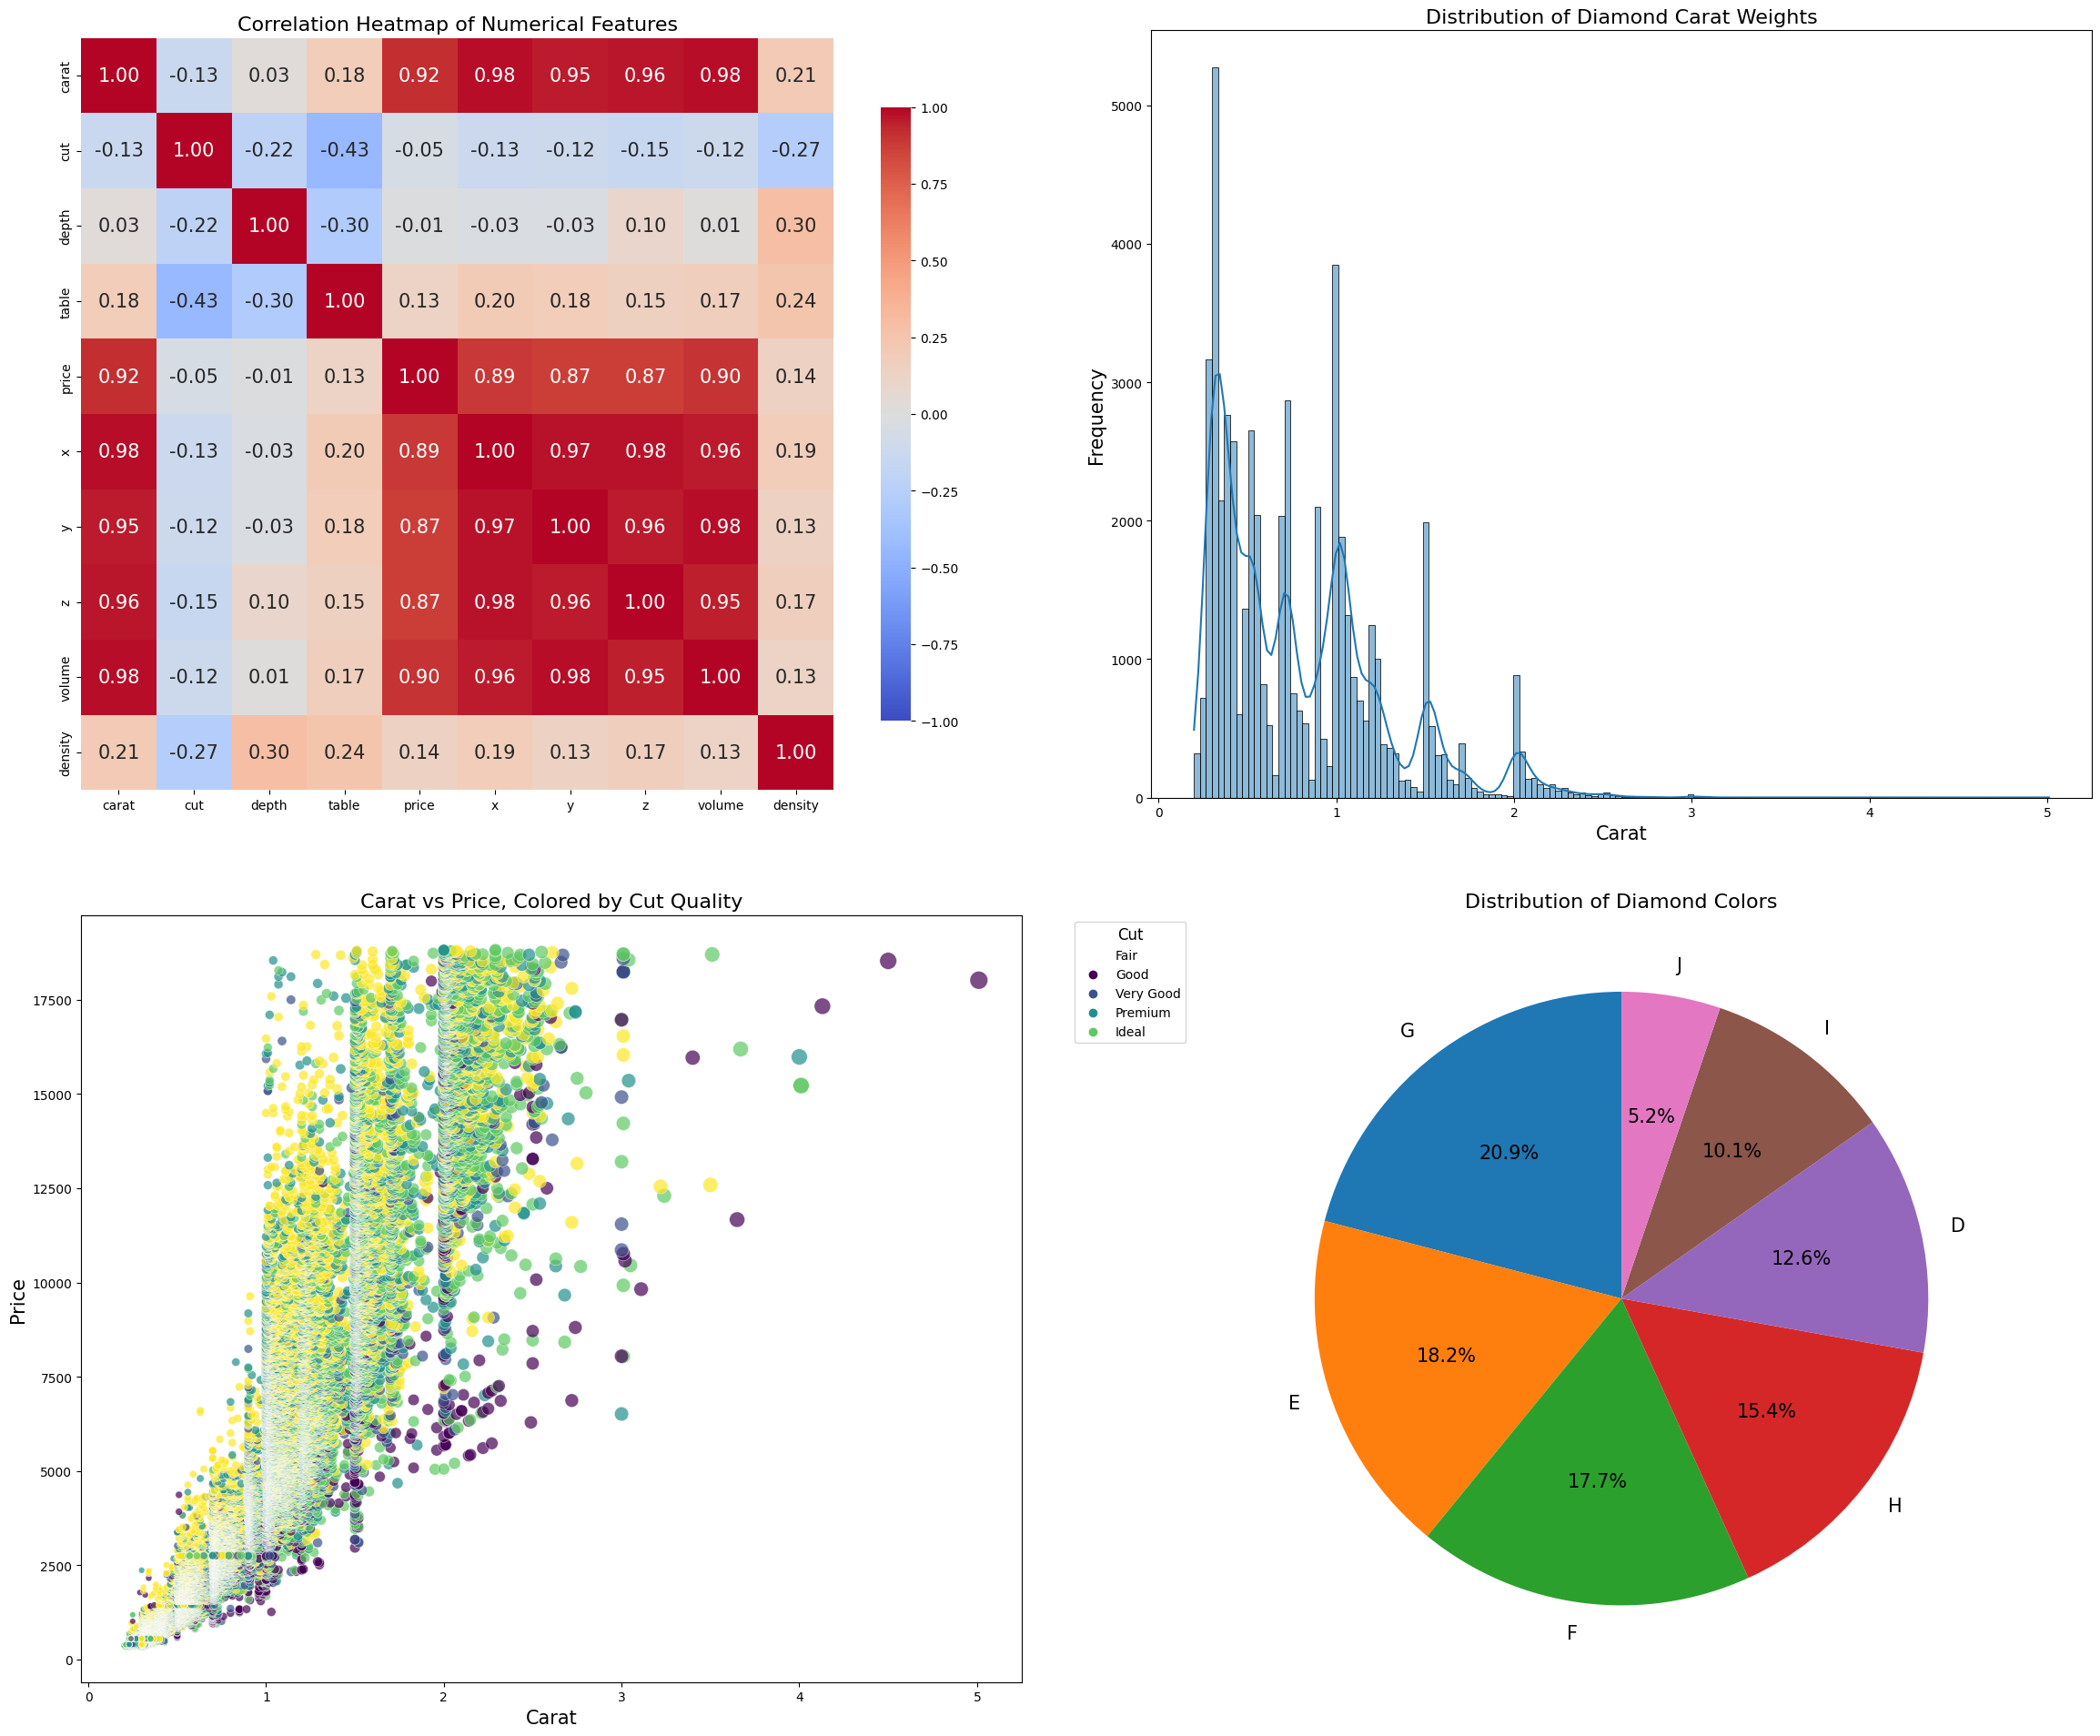

In [ ]:
plt.figure(figsize=(24, 20))

# 1. Correlation Heatmap
plt.subplot(2, 2, 1)
correlation_matrix = df.select_dtypes(include=[np.number]).corr()
sns.heatmap(correlation_matrix, annot=True, cmap='coolwarm', center=0, vmin=-1, vmax=1, square=True,
            cbar_kws={'shrink': .8}, fmt='.2f', annot_kws={'size': 15})
plt.title('Correlation Heatmap of Numerical Features', fontsize=16)
plt.tight_layout()

# 2. Distribution of Carat Weights
plt.subplot(2, 2, 2)
sns.histplot(df['carat'], kde=True)
plt.title('Distribution of Diamond Carat Weights', fontsize=16)
plt.xlabel('Carat', fontsize=15)
plt.ylabel('Frequency', fontsize=15)

# 3. Scatter Plot of Carat vs Price, colored by Cut
plt.subplot(2, 2, 3)
scatter = sns.scatterplot(x='carat', y='price', hue='cut', data=df, palette='viridis',
                          size='carat', sizes=(20, 200), alpha=0.7)
plt.title('Carat vs Price, Colored by Cut Quality', fontsize=16)
plt.xlabel('Carat', fontsize=15)
plt.ylabel('Price', fontsize=15)

# Modify the legend to use the original cut names
cut_labels = ['Fair', 'Good', 'Very Good', 'Premium', 'Ideal']
handles, labels = scatter.get_legend_handles_labels()
scatter.legend(handles, cut_labels, title='Cut', title_fontsize=12, bbox_to_anchor=(1.05, 1), loc='upper left')

# 4. Color Distribution
plt.subplot(2, 2, 4)
color_counts = df['color'].value_counts()
plt.pie(color_counts.values, labels=color_counts.index, autopct='%1.1f%%',
        textprops={'fontsize': 15}, startangle=90)
plt.title('Distribution of Diamond Colors', fontsize=16)

plt.tight_layout(pad=4.0)
plt.show()

# Training Parameter Setup

In [ ]:
# Split features and target
X = df.drop('cut', axis=1)
y = df['cut']

# Split data
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42, stratify=y
)

In [ ]:
X_train.shape, X_test.shape, y_train.shape, y_test.shape

((43136, 11), (10784, 11), (43136,), (10784,))

In [ ]:
# Preprocessing pipeline
categorical_features = ['color', 'clarity']
numerical_features = ['carat', 'depth', 'table', 'price',
                     'x', 'y', 'z', 'volume', 'density']

In [ ]:
preprocessor = Pipeline(steps=[
    ('ct', ColumnTransformer(
        transformers=[
            ('num', Pipeline(steps=[
                ('imputer', SimpleImputer(strategy='median'))
            ]), numerical_features),
            ('cat', OneHotEncoder(handle_unknown='ignore'), categorical_features)
        ])),
    ('inf_imputer', SimpleImputer(missing_values=np.inf, strategy='median'))
])

In [ ]:
# Fit and transform data to arrays
X_train_processed = preprocessor.fit_transform(X_train)
X_test_processed = preprocessor.transform(X_test)

In [ ]:
# Get feature names
cat_features = preprocessor.named_steps['ct'].named_transformers_['cat'].get_feature_names_out(categorical_features)
feature_names = numerical_features + list(cat_features)

In [ ]:
# Convert to float32 for GPU compatibility
X_train_processed = X_train_processed.astype(np.float32)
X_test_processed = X_test_processed.astype(np.float32)

# Model 1: RandomForestClassifier

In [ ]:
# Initialize and train
model1 = RandomForestClassifier(
    n_estimators=200,
    max_depth=12,
    class_weight='balanced',
    random_state=42,
    n_jobs=-1
)
model1.fit(X_train_processed, y_train)

RandomForestClassifier(class_weight='balanced', max_depth=12, n_estimators=200,
                       n_jobs=-1, random_state=42)

# Model 2: KNeighborsClassifier

In [ ]:
# Create new pipeline with scaling for KNN
model2 = Pipeline([
    ('preprocessor', preprocessor),
    ('scaler', StandardScaler()),
    ('knn', KNeighborsClassifier(
        n_neighbors=15,
        weights='distance',
        metric='manhattan',
        n_jobs=-1
    ))
])

In [ ]:
# Fit on original X_train
model2.fit(X_train, y_train)

Pipeline(steps=[('preprocessor',
                 Pipeline(steps=[('ct',
                                  ColumnTransformer(transformers=[('num',
                                                                   Pipeline(steps=[('imputer',
                                                                                    SimpleImputer(strategy='median'))]),
                                                                   ['carat',
                                                                    'depth',
                                                                    'table',
                                                                    'price',
                                                                    'x', 'y',
                                                                    'z',
                                                                    'volume',
                                                                    'density']),
                                                                  ('cat',
                                                                   OneHotEncoder(handle_unknown='ignore'),
                                                                   ['color',
                                                                    'clarity'])])),
                                 ('inf_imputer',
                                  SimpleImputer(missing_values=inf,
                                                strategy='median'))])),
                ('scaler', StandardScaler()),
                ('knn',
                 KNeighborsClassifier(metric='manhattan', n_jobs=-1,
                                      n_neighbors=15, weights='distance'))])

# Model 3: XGBoost

In [ ]:
# Create DMatrix for XGBoost
dtrain = xgb.DMatrix(X_train_processed, label=y_train, feature_names=feature_names)
dtest = xgb.DMatrix(X_test_processed, label=y_test, feature_names=feature_names)

In [ ]:
# GPU-accelerated parameters
params = {
    'objective': 'multi:softprob',
    'num_class': 5,
    'eval_metric': ['mlogloss', 'merror'],
    'tree_method': 'gpu_hist',
    'gpu_id': 0,
    'eta': 0.1,
    'max_depth': 6,
    'subsample': 0.8,
    'colsample_bytree': 0.8,
    'seed': 42
}

In [ ]:
# Train model
model3 = xgb.train(
    params,
    dtrain,
    num_boost_round=1000,
    evals=[(dtrain, 'train'), (dtest, 'test')],
    early_stopping_rounds=20,
    verbose_eval=50
)

[06:00:06] WARNING: /workspace/src/common/error_msg.cc:45: `gpu_id` is deprecated since2.0.0, use `device` instead. E.g. device=cpu/cuda/cuda:0
[06:00:06] WARNING: /workspace/src/common/error_msg.cc:27: The tree method `gpu_hist` is deprecated since 2.0.0. To use GPU training, set the `device` parameter to CUDA instead.

    E.g. tree_method = "hist", device = "cuda"



[0]	train-mlogloss:1.50797	train-merror:0.30696	test-mlogloss:1.50803	test-merror:0.29868
[50]	train-mlogloss:0.62289	train-merror:0.23686	test-mlogloss:0.64443	test-merror:0.24212
[100]	train-mlogloss:0.53974	train-merror:0.20829	test-mlogloss:0.59116	test-merror:0.22162
[150]	train-mlogloss:0.48467	train-merror:0.18254	test-mlogloss:0.56272	test-merror:0.20521
[200]	train-mlogloss:0.44383	train-merror:0.16346	test-mlogloss:0.54507	test-merror:0.19853
[250]	train-mlogloss:0.41021	train-merror:0.14691	test-mlogloss:0.53275	test-merror:0.19399
[276]	train-mlogloss:0.39430	train-merror:0.14005	test-mlogloss:0.52746	test-merror:0.19325


# Model 4: Gradient Boosting Machines

In [ ]:
model4 = Pipeline([
    ('preprocessor', preprocessor),
    ('scaler', StandardScaler()),  # optional, but often helpful
    ('gbm', GradientBoostingClassifier(
        n_estimators=100,
        learning_rate=0.1,
        max_depth=6,
        random_state=42
    ))
])

In [ ]:
model4.fit(X_train, y_train)

Pipeline(steps=[('preprocessor',
                 Pipeline(steps=[('ct',
                                  ColumnTransformer(transformers=[('num',
                                                                   Pipeline(steps=[('imputer',
                                                                                    SimpleImputer(strategy='median'))]),
                                                                   ['carat',
                                                                    'depth',
                                                                    'table',
                                                                    'price',
                                                                    'x', 'y',
                                                                    'z',
                                                                    'volume',
                                                                    'density']),
                                                                  ('cat',
                                                                   OneHotEncoder(handle_unknown='ignore'),
                                                                   ['color',
                                                                    'clarity'])])),
                                 ('inf_imputer',
                                  SimpleImputer(missing_values=inf,
                                                strategy='median'))])),
                ('scaler', StandardScaler()),
                ('gbm',
                 GradientBoostingClassifier(max_depth=6, random_state=42))])

# Model 5: Logistic Regression

In [ ]:
model5 = Pipeline([
    ('preprocessor', preprocessor),
    ('scaler', StandardScaler()),
    ('logreg', LogisticRegression(
        penalty='l2',
        C=1.0,
        max_iter=1000,
        random_state=42
    ))
])

In [ ]:
model5.fit(X_train, y_train)

Pipeline(steps=[('preprocessor',
                 Pipeline(steps=[('ct',
                                  ColumnTransformer(transformers=[('num',
                                                                   Pipeline(steps=[('imputer',
                                                                                    SimpleImputer(strategy='median'))]),
                                                                   ['carat',
                                                                    'depth',
                                                                    'table',
                                                                    'price',
                                                                    'x', 'y',
                                                                    'z',
                                                                    'volume',
                                                                    'density']),
                                                                  ('cat',
                                                                   OneHotEncoder(handle_unknown='ignore'),
                                                                   ['color',
                                                                    'clarity'])])),
                                 ('inf_imputer',
                                  SimpleImputer(missing_values=inf,
                                                strategy='median'))])),
                ('scaler', StandardScaler()),
                ('logreg', LogisticRegression(max_iter=1000, random_state=42))])

# Evaluations

In [ ]:
#Random Forest
y_pred_rf = model1.predict(X_test_processed)

#KNN
y_pred_knn = model2.predict(X_test)

#XGB
xgb_pred_probs = model3.predict(dtest)
xgb_pred_classes = np.argmax(xgb_pred_probs, axis=1)

#GBM
y_pred_gbm = model4.predict(X_test)

#LR
y_pred_logreg = model5.predict(X_test)

[06:02:18] WARNING: /workspace/src/common/error_msg.cc:27: The tree method `gpu_hist` is deprecated since 2.0.0. To use GPU training, set the `device` parameter to CUDA instead.

    E.g. tree_method = "hist", device = "cuda"



In [ ]:
# Prepare the data
models = ['Random Forest', 'KNN', 'XGBoost', 'GBM', 'Logistic Regression']
accuracy = [
    accuracy_score(y_test, y_pred_rf),
    accuracy_score(y_test, y_pred_knn),
    accuracy_score(y_test, xgb_pred_classes),
    accuracy_score(y_test, y_pred_gbm),
    accuracy_score(y_test, y_pred_logreg)
]
cohen_kappa = [
    cohen_kappa_score(y_test, y_pred_rf, weights='quadratic'),
    cohen_kappa_score(y_test, y_pred_knn, weights='quadratic'),
    cohen_kappa_score(y_test, xgb_pred_classes, weights='quadratic'),
    cohen_kappa_score(y_test, y_pred_gbm, weights='quadratic'),
    cohen_kappa_score(y_test, y_pred_logreg, weights='quadratic')
]
f1_macro = [
    f1_score(y_test, y_pred_rf, average='macro'),
    f1_score(y_test, y_pred_knn, average='macro'),
    f1_score(y_test, xgb_pred_classes, average='macro'),
    f1_score(y_test, y_pred_gbm, average='macro'),
    f1_score(y_test, y_pred_logreg, average='macro')
]

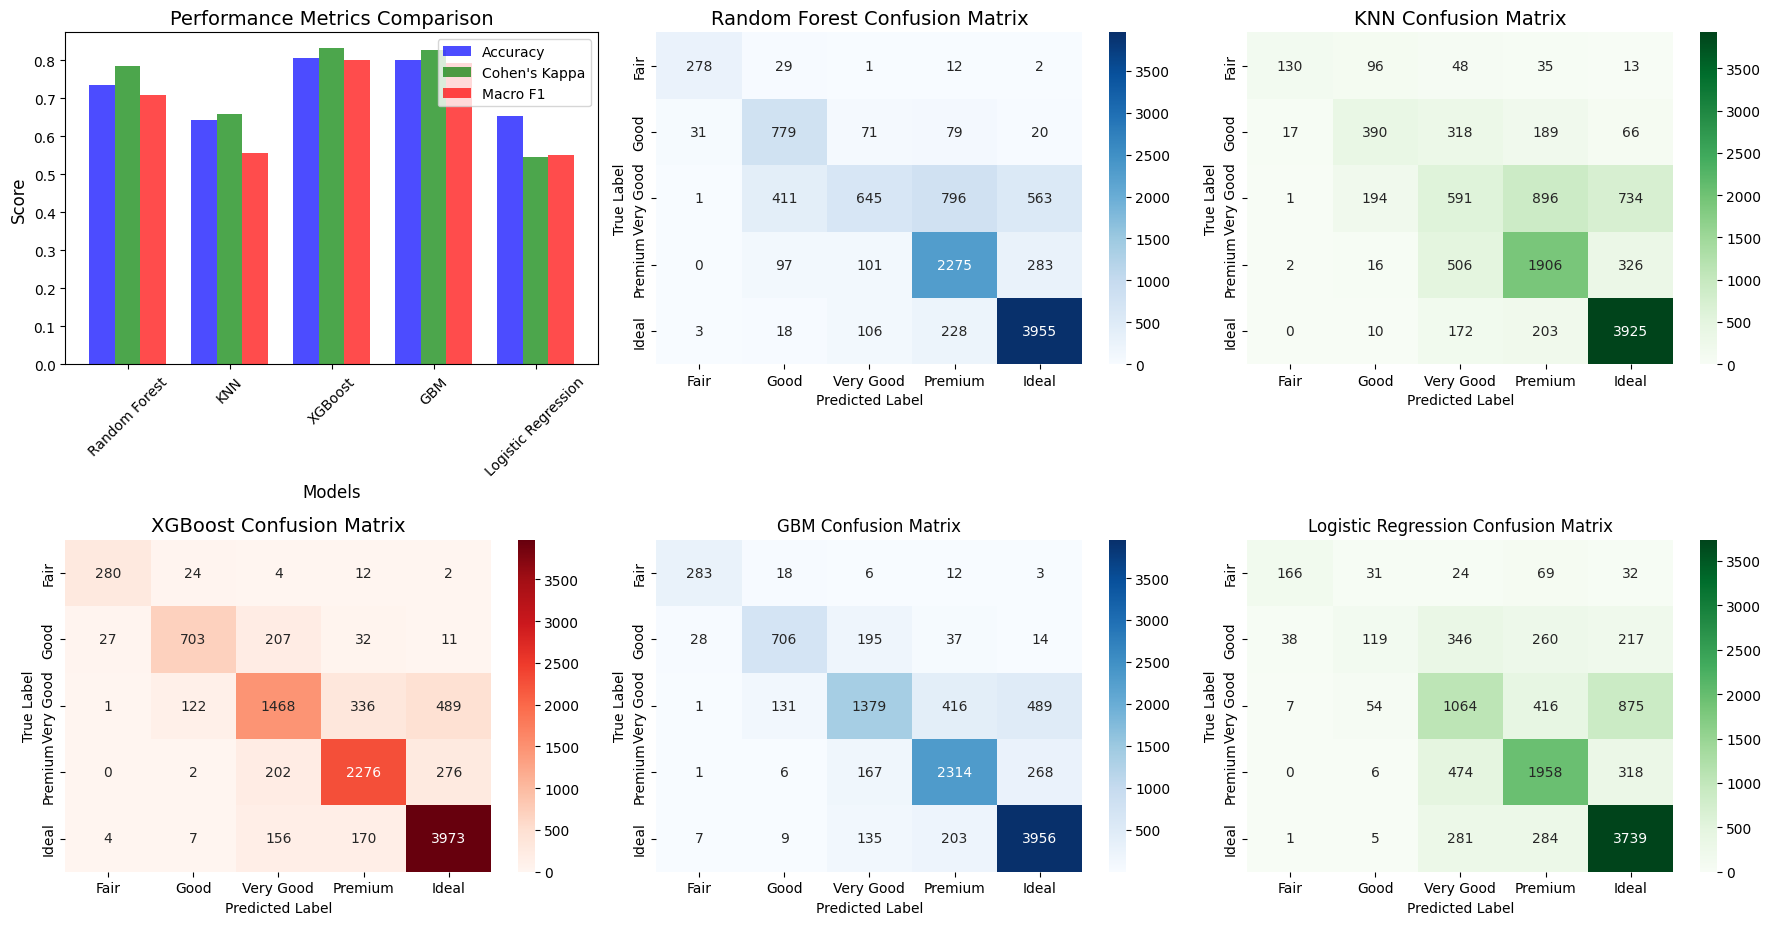

In [ ]:
# Set up the plotting
plt.figure(figsize=(18, 14))
grid_rows = 3
grid_cols = 3


# 1. Bar Plot of Performance Metrics
plt.subplot(grid_rows, grid_cols, 1)
x = np.arange(len(models))
width = 0.25

plt.bar(x - width, accuracy, width, label='Accuracy', color='blue', alpha=0.7)
plt.bar(x, cohen_kappa, width, label="Cohen's Kappa", color='green', alpha=0.7)
plt.bar(x + width, f1_macro, width, label='Macro F1', color='red', alpha=0.7)

plt.xlabel('Models', fontsize=12)
plt.ylabel('Score', fontsize=12)
plt.title('Performance Metrics Comparison', fontsize=14)
plt.xticks(x, models, rotation=45)
plt.legend()
plt.tight_layout()


# RF
plt.subplot(grid_rows, grid_cols, 2)
cm_rf = confusion_matrix(y_test, y_pred_rf)
sns.heatmap(cm_rf, annot=True, fmt='d', cmap='Blues',
            xticklabels=cut_order, yticklabels=cut_order)
plt.title('Random Forest Confusion Matrix', fontsize=14)
plt.xlabel('Predicted Label', fontsize=10)
plt.ylabel('True Label', fontsize=10)


# KNN
plt.subplot(grid_rows, grid_cols, 3)
cm_knn = confusion_matrix(y_test, y_pred_knn)
sns.heatmap(cm_knn, annot=True, fmt='d', cmap='Greens',
            xticklabels=cut_order, yticklabels=cut_order)
plt.title('KNN Confusion Matrix', fontsize=14)
plt.xlabel('Predicted Label', fontsize=10)
plt.ylabel('True Label', fontsize=10)


#XGBoost
plt.subplot(grid_rows, grid_cols, 4)
cm_xgb = confusion_matrix(y_test, xgb_pred_classes)
sns.heatmap(cm_xgb, annot=True, fmt='d', cmap='Reds',
            xticklabels=cut_order, yticklabels=cut_order)
plt.title('XGBoost Confusion Matrix', fontsize=14)
plt.xlabel('Predicted Label', fontsize=10)
plt.ylabel('True Label', fontsize=10)


#GBM
plt.subplot(grid_rows, grid_cols, 5)
cm_gbm = confusion_matrix(y_test, y_pred_gbm)
sns.heatmap(cm_gbm, annot=True, fmt='d', cmap='Blues',
            xticklabels=cut_order, yticklabels=cut_order)
plt.title('GBM Confusion Matrix')
plt.xlabel('Predicted Label')
plt.ylabel('True Label')


#LR
plt.subplot(grid_rows, grid_cols, 6)
cm_lr = confusion_matrix(y_test, y_pred_logreg)
sns.heatmap(cm_lr, annot=True, fmt='d', cmap='Greens',
            xticklabels=cut_order, yticklabels=cut_order)
plt.title('Logistic Regression Confusion Matrix')
plt.xlabel('Predicted Label')
plt.ylabel('True Label')


plt.tight_layout()
plt.show()

In [ ]:
# Prepare a detailed performance summary
print("\nDetailed Model Performance Summary:")
print("-" * 50)
for i, model in enumerate(models):
    print(f"\n{model} Performance:")
    print(f"Accuracy: {accuracy[i]:.3f}")
    print(f"Cohen's Kappa: {cohen_kappa[i]:.3f}")
    print(f"Macro F1 Score: {f1_macro[i]:.3f}")


Detailed Model Performance Summary:
--------------------------------------------------

Random Forest Performance:
Accuracy: 0.736
Cohen's Kappa: 0.787
Macro F1 Score: 0.708

KNN Performance:
Accuracy: 0.644
Cohen's Kappa: 0.659
Macro F1 Score: 0.556

XGBoost Performance:
Accuracy: 0.807
Cohen's Kappa: 0.832
Macro F1 Score: 0.800

GBM Performance:
Accuracy: 0.801
Cohen's Kappa: 0.826
Macro F1 Score: 0.794

Logistic Regression Performance:
Accuracy: 0.653
Cohen's Kappa: 0.546
Macro F1 Score: 0.551


# Prediction of New Data

In [ ]:
new_data = pd.DataFrame({
    'carat': [0.75, 1.2],
    'color': ['D', 'G'],
    'clarity': ['SI1', 'VS2'],
    'depth': [62.1, 58.3],
    'table': [57, 59],
    'price': [2757, 5820],
    'x': [5.83, 6.89],
    'y': [5.87, 6.92],
    'z': [3.64, 4.12]
})

In [ ]:
new_data['volume'] = new_data['x'] * new_data['y'] * new_data['z']
new_data['density'] = new_data['carat'] / (new_data['volume'] + 1e-6)
new_data_processed = preprocessor.transform(new_data).astype(np.float32)

In [ ]:
print("Random Forest:", [cut_order[p] for p in model1.predict(new_data_processed)])
print("KNN:", [cut_order[p] for p in model2.predict(new_data)])


dnew = xgb.DMatrix(new_data_processed, feature_names=feature_names)
new_preds = np.argmax(model3.predict(dnew), axis=1)
predicted_cuts = [cut_order[p] for p in new_preds]
print(f"XGBoost: {predicted_cuts}")


gbm_new_preds = model4.predict(new_data)  # Pipeline includes preprocessing
print("Gradient Boosting:", [cut_order[p] for p in gbm_new_preds])


logreg_new_preds = model5.predict(new_data)
print("Logistic Regression:", [cut_order[p] for p in logreg_new_preds])

Random Forest: ['Ideal', 'Premium']
KNN: ['Ideal', 'Premium']
XGBoost: ['Ideal', 'Premium']
Gradient Boosting: ['Ideal', 'Premium']
Logistic Regression: ['Very Good', 'Premium']


# Fine Tuning

In [ ]:
import sklearn
print(sklearn.__version__)

1.2.2


In [ ]:
from xgboost import XGBClassifier
from sklearn.model_selection import RandomizedSearchCV

In [ ]:
# XGBClassifier for multiclass classification
xgb_clf = XGBClassifier(
    objective='multi:softprob',
    num_class=5,               # We have 5 classes for cut
    tree_method='gpu_hist',
    device='cuda',
    predictor='gpu_predictor',
    eval_metric='merror', # 'merror' so that early stopping aligns with accuracy
    random_state=42
)

param_dist = {
    "learning_rate":      [0.05, 0.1, 0.2],      # Closer to your original 0.1
    "max_depth":          [4, 5, 6, 7],          # Around your original 6
    "min_child_weight":   [1, 3, 5],             # Only a few values
    "gamma":              [0, 0.1, 0.2],         # A smaller range
    "subsample":          [0.8, 0.9, 1.0],       # Around your original 0.8
    "colsample_bytree":   [0.7, 0.8, 0.9],       # Around your original 0.8
    "n_estimators":       [100, 200, 400],       # Not too low, not too high
    "alpha":              [0, 0.5, 1.0],         # L1 regularization
    "lambda":             [0.5, 1.0, 2.0]        # L2 regularization
}

# param_dist = {
#     "learning_rate":      [0.15, 0.2, 0.25],    # Narrow around 0.2
#     "max_depth":          [4, 5, 6],            # Centered around 5
#     "min_child_weight":   [3, 5, 7],            # Centered around 5
#     "gamma":              [0.1, 0.2, 0.3],      # Centered around 0.2
#     "subsample":          [0.8, 0.9, 1.0],      # Keep 0.9 plus a bit around
#     "colsample_bytree":   [0.6, 0.7, 0.8],      # Centered around 0.7
#     "n_estimators":       [300, 400, 500],      # Keep 400 plus a bit around
#     "alpha":              [0, 0.5, 1.0],        # 0.5 is the best, keep 0 and 1 for range
#     "lambda":             [0.5, 1.0, 1.5]       # 1.0 is best, keep slight range
# }

In [ ]:
random_search = RandomizedSearchCV(
    estimator=xgb_clf,
    param_distributions=param_dist,
    scoring='accuracy',             # We'll select the best model by accuracy
    n_iter=20,                      # Try ~40 random combos in the narrower space
    cv=5,                           # 5-fold cross validation to reduce variance
    verbose=1,
    random_state=42,
    n_jobs=-1
)

In [ ]:
random_search.fit(
    X_train_processed,
    y_train,
    eval_set=[(X_test_processed, y_test)],
    early_stopping_rounds=20,
    verbose=True
)

Fitting 5 folds for each of 20 candidates, totalling 100 fits
[0]	validation_0-merror:0.30629
[1]	validation_0-merror:0.28681
[2]	validation_0-merror:0.25668
[3]	validation_0-merror:0.25009
[4]	validation_0-merror:0.24796


`early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.
[06:07:02] WARNING: /workspace/src/common/error_msg.cc:27: The tree method `gpu_hist` is deprecated since 2.0.0. To use GPU training, set the `device` parameter to CUDA instead.

    E.g. tree_method = "hist", device = "cuda"

[06:07:02] WARNING: /workspace/src/learner.cc:742: 
Parameters: { "predictor" } are not used.



[5]	validation_0-merror:0.24675
[6]	validation_0-merror:0.24703
[7]	validation_0-merror:0.24666
[8]	validation_0-merror:0.24490
[9]	validation_0-merror:0.24462
[10]	validation_0-merror:0.24379
[11]	validation_0-merror:0.24258
[12]	validation_0-merror:0.24203
[13]	validation_0-merror:0.24138
[14]	validation_0-merror:0.24147
[15]	validation_0-merror:0.24063
[16]	validation_0-merror:0.24026
[17]	validation_0-merror:0.24017
[18]	validation_0-merror:0.24026
[19]	validation_0-merror:0.23934
[20]	validation_0-merror:0.23869
[21]	validation_0-merror:0.23813
[22]	validation_0-merror:0.23776
[23]	validation_0-merror:0.23739
[24]	validation_0-merror:0.23711
[25]	validation_0-merror:0.23498
[26]	validation_0-merror:0.23210
[27]	validation_0-merror:0.23164
[28]	validation_0-merror:0.23062
[29]	validation_0-merror:0.22997
[30]	validation_0-merror:0.23034
[31]	validation_0-merror:0.23043
[32]	validation_0-merror:0.22923
[33]	validation_0-merror:0.22765
[34]	validation_0-merror:0.22691
[35]	validation

RandomizedSearchCV(cv=5,
                   estimator=XGBClassifier(base_score=None, booster=None,
                                           callbacks=None,
                                           colsample_bylevel=None,
                                           colsample_bynode=None,
                                           colsample_bytree=None, device='cuda',
                                           early_stopping_rounds=None,
                                           enable_categorical=False,
                                           eval_metric='merror',
                                           feature_types=None, gamma=None,
                                           grow_policy=None,
                                           importance_type=None,
                                           interaction_constraints=None,
                                           learnin...
                                           num_class=5, num_parallel_tree=None, ...),
                   n_iter=20, n_jobs=-1,
                   param_distributions={'alpha': [0, 0.5, 1.0],
                                        'colsample_bytree': [0.7, 0.8, 0.9],
                                        'gamma': [0, 0.1, 0.2],
                                        'lambda': [0.5, 1.0, 2.0],
                                        'learning_rate': [0.05, 0.1, 0.2],
                                        'max_depth': [4, 5, 6, 7],
                                        'min_child_weight': [1, 3, 5],
                                        'n_estimators': [100, 200, 400],
                                        'subsample': [0.8, 0.9, 1.0]},
                   random_state=42, scoring='accuracy', verbose=1)

In [ ]:
print("Best parameters found: ", random_search.best_params_)
print("Best cross-validation accuracy: ", random_search.best_score_)

Best parameters found:  {'subsample': 0.8, 'n_estimators': 200, 'min_child_weight': 1, 'max_depth': 7, 'learning_rate': 0.2, 'lambda': 0.5, 'gamma': 0, 'colsample_bytree': 0.8, 'alpha': 0.5}
Best cross-validation accuracy:  0.7951827179055696


In [ ]:
best_xgb = random_search.best_estimator_

In [ ]:
y_pred_best = best_xgb.predict(X_test_processed)

acc = accuracy_score(y_test, y_pred_best)
f1 = f1_score(y_test, y_pred_best, average='macro')
kappa = cohen_kappa_score(y_test, y_pred_best, weights='quadratic')

print("\nBest XGBoost Test Accuracy:", acc)
print("Best XGBoost Test Macro F1:", f1)
print("Best XGBoost Test Cohen's Kappa:", kappa)


Best XGBoost Test Accuracy: 0.8106454005934718
Best XGBoost Test Macro F1: 0.8051392367129546
Best XGBoost Test Cohen's Kappa: 0.8357294234050143


[06:07:05] WARNING: /workspace/src/common/error_msg.cc:27: The tree method `gpu_hist` is deprecated since 2.0.0. To use GPU training, set the `device` parameter to CUDA instead.

    E.g. tree_method = "hist", device = "cuda"

[06:07:05] WARNING: /workspace/src/common/error_msg.cc:58: Falling back to prediction using DMatrix due to mismatched devices. This might lead to higher memory usage and slower performance. XGBoost is running on: cuda:0, while the input data is on: cpu.
Potential solutions:
- Use a data structure that matches the device ordinal in the booster.
- Set the device for booster before call to inplace_predict.

This warning will only be shown once.



In [ ]:
best_new_preds = best_xgb.predict(new_data_processed)
print("Tuned XGBoost:", [cut_order[p] for p in best_new_preds])

Tuned XGBoost: ['Ideal', 'Premium']


# Extra Fine Tuning (The other 20%)

Identify which training examples are consistently misclassified (come from a class that's confused) and then “upweight” these samples by assigning them higher sample weights during training. This “hard example mining” approach forces the model to pay extra attention to those problematic cases.

In [ ]:
# Identify which training examples (or classes) are often misclassified.
# Use best‐tuned XGBoost model (best_xgb) to predict on the training data.
train_preds = best_xgb.predict(X_train_processed)
misclassified_idx = np.where(train_preds != y_train)[0]
misclass_rate = len(misclassified_idx) / len(y_train)
print("Training misclassification rate (before reweighting): {:.2%}".format(misclass_rate))

Training misclassification rate (before reweighting): 11.86%


In [ ]:
# For a targeted weight increase, we create a sample_weight vector.
# By default, all samples get weight 1.0; we upweight the hard cases by a factor (e.g., 2.0).
sample_weights = np.ones(len(y_train), dtype=float)
sample_weights[misclassified_idx] = 1.1

from collections import Counter
misclassified_classes = Counter(y_train.iloc[misclassified_idx])
print("Misclassified class counts:", misclassified_classes)

Misclassified class counts: Counter({2: 2565, 3: 1274, 4: 826, 1: 433, 0: 19})


In [ ]:
# Retrain a new XGBoost model using these sample weights.
# We use the same tuned hyperparameters from the best model.
# (The best parameters are stored in random_search.best_params_)
tuned_params = random_search.best_params_

weighted_xgb = XGBClassifier(
    objective='multi:softprob',
    num_class=5,
    tree_method='gpu_hist',
    predictor='gpu_predictor',
    eval_metric='merror',
    random_state=42,
    learning_rate=tuned_params.get('learning_rate', 0.1),
    max_depth=tuned_params.get('max_depth', 6),
    min_child_weight=tuned_params.get('min_child_weight', 1),
    gamma=tuned_params.get('gamma', 0),
    subsample=tuned_params.get('subsample', 0.8),
    colsample_bytree=tuned_params.get('colsample_bytree', 0.8),
    n_estimators=tuned_params.get('n_estimators', 200),
    reg_alpha=tuned_params.get('alpha', 0),
    reg_lambda=tuned_params.get('lambda', 1.0)
)

weighted_xgb.fit(
    X_train_processed,
    y_train,
    sample_weight=sample_weights,
    eval_set=[(X_test_processed, y_test)],
    early_stopping_rounds=20,
    verbose=True
)

`early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.


[0]	validation_0-merror:0.30768


[06:07:05] WARNING: /workspace/src/common/error_msg.cc:27: The tree method `gpu_hist` is deprecated since 2.0.0. To use GPU training, set the `device` parameter to CUDA instead.

    E.g. tree_method = "hist", device = "cuda"

[06:07:05] WARNING: /workspace/src/learner.cc:742: 
Parameters: { "predictor" } are not used.



[1]	validation_0-merror:0.28644
[2]	validation_0-merror:0.25807
[3]	validation_0-merror:0.24898
[4]	validation_0-merror:0.24861
[5]	validation_0-merror:0.24666
[6]	validation_0-merror:0.24629
[7]	validation_0-merror:0.24601
[8]	validation_0-merror:0.24407
[9]	validation_0-merror:0.24518
[10]	validation_0-merror:0.24536
[11]	validation_0-merror:0.24342
[12]	validation_0-merror:0.24286
[13]	validation_0-merror:0.24175
[14]	validation_0-merror:0.24128
[15]	validation_0-merror:0.24165
[16]	validation_0-merror:0.24119
[17]	validation_0-merror:0.24073
[18]	validation_0-merror:0.23989
[19]	validation_0-merror:0.24008
[20]	validation_0-merror:0.23924
[21]	validation_0-merror:0.23841
[22]	validation_0-merror:0.23739
[23]	validation_0-merror:0.23683
[24]	validation_0-merror:0.23683
[25]	validation_0-merror:0.23646
[26]	validation_0-merror:0.23377
[27]	validation_0-merror:0.23368
[28]	validation_0-merror:0.23164
[29]	validation_0-merror:0.23145
[30]	validation_0-merror:0.23173
[31]	validation_0-m

XGBClassifier(base_score=None, booster=None, callbacks=None,
              colsample_bylevel=None, colsample_bynode=None,
              colsample_bytree=0.8, device=None, early_stopping_rounds=None,
              enable_categorical=False, eval_metric='merror',
              feature_types=None, gamma=0, grow_policy=None,
              importance_type=None, interaction_constraints=None,
              learning_rate=0.2, max_bin=None, max_cat_threshold=None,
              max_cat_to_onehot=None, max_delta_step=None, max_depth=7,
              max_leaves=None, min_child_weight=1, missing=nan,
              monotone_constraints=None, multi_strategy=None, n_estimators=200,
              n_jobs=None, num_class=5, num_parallel_tree=None, ...)

In [ ]:
# Evaluate the retrained (weighted) model on your test set.
weighted_preds = weighted_xgb.predict(X_test_processed)
acc_weighted = accuracy_score(y_test, weighted_preds)
f1_weighted  = f1_score(y_test, weighted_preds, average='macro')
kappa_weighted = cohen_kappa_score(y_test, weighted_preds, weights='quadratic')

print("\nWeighted XGBoost Test Metrics:")
print("  Accuracy:        {:.3f}".format(acc_weighted))
print("  Macro F1 Score:  {:.3f}".format(f1_weighted))
print("  Cohen's Kappa:   {:.3f}".format(kappa_weighted))


Weighted XGBoost Test Metrics:
  Accuracy:        0.814
  Macro F1 Score:  0.809
  Cohen's Kappa:   0.838


[06:07:08] WARNING: /workspace/src/common/error_msg.cc:27: The tree method `gpu_hist` is deprecated since 2.0.0. To use GPU training, set the `device` parameter to CUDA instead.

    E.g. tree_method = "hist", device = "cuda"



# Comarpsion: XGB vs Fine-Tuned XGB Model vs Weighted XGB

In [ ]:
original_preds = xgb_pred_classes
tuned_preds = y_pred_best
weighted_preds = weighted_preds

In [ ]:
metrics = ['Accuracy', 'F1 Macro', "Cohen's Kappa"]
original_scores = [
    accuracy_score(y_test, original_preds),
    f1_score(y_test, original_preds, average='macro'),
    cohen_kappa_score(y_test, original_preds, weights='quadratic')
]

In [ ]:
tuned_scores = [
    accuracy_score(y_test, tuned_preds),
    f1_score(y_test, tuned_preds, average='macro'),
    cohen_kappa_score(y_test, tuned_preds, weights='quadratic')
]

In [ ]:
weighted_scores = [
    accuracy_score(y_test, weighted_preds),
    f1_score(y_test, weighted_preds, average='macro'),
    cohen_kappa_score(y_test, weighted_preds, weights='quadratic')
]

In [ ]:
original_scores

[0.8067507418397626, 0.7999993866358457, 0.8320033692151472]

In [ ]:
tuned_scores

[0.8106454005934718, 0.8051392367129546, 0.8357294234050143]

In [ ]:
weighted_scores

[0.8143545994065282, 0.8089197071630438, 0.8382795378259826]

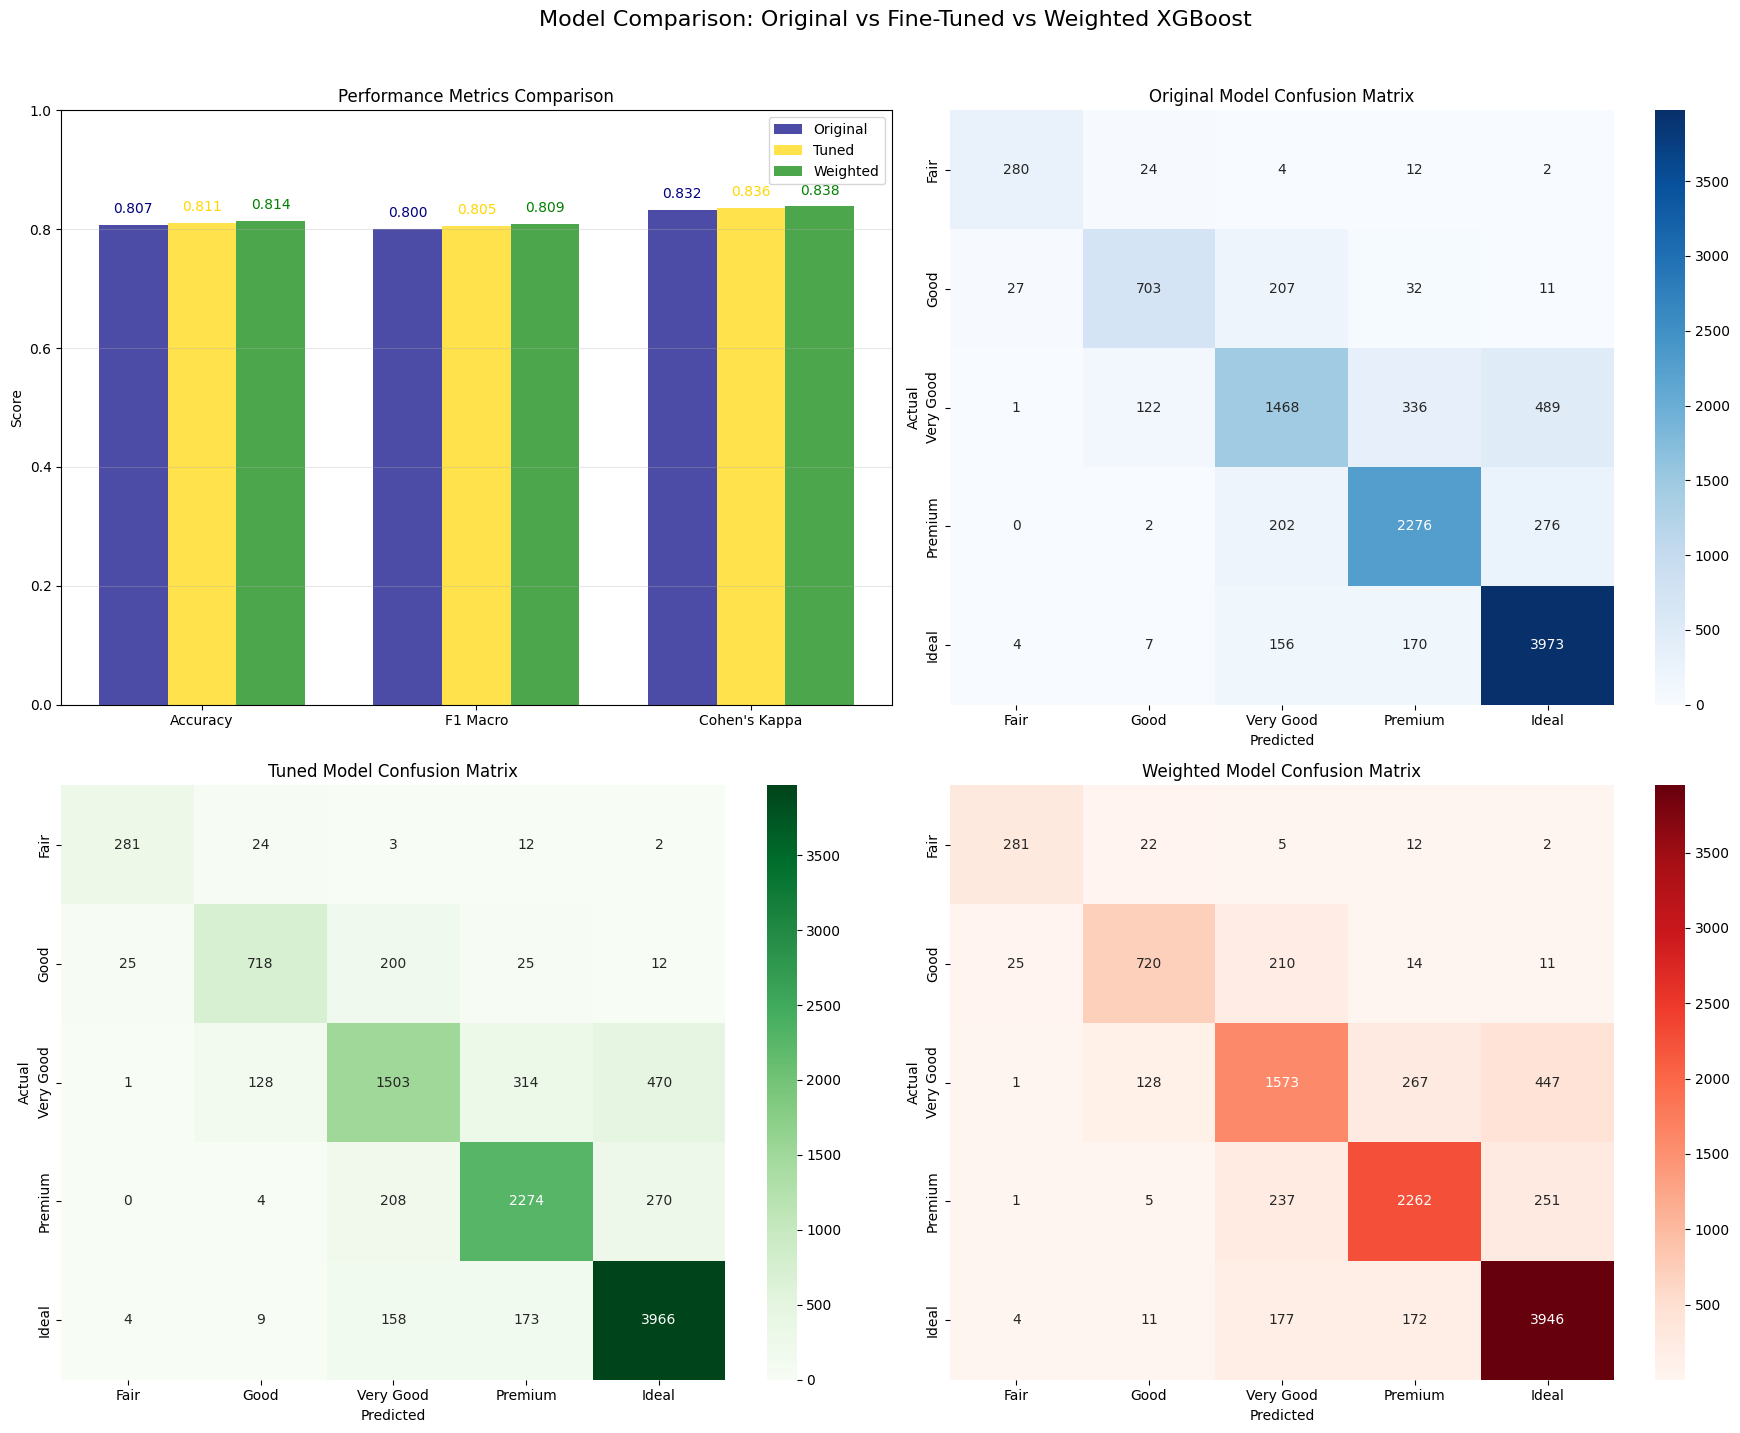

In [ ]:
plt.figure(figsize=(18, 14))
plt.suptitle("Model Comparison: Original vs Fine-Tuned vs Weighted XGBoost", y=1.02, fontsize=16)

plt.subplot(2, 2, 1)
x = np.arange(len(metrics))
width = 0.25  # set a smaller width to accommodate three groups

plt.bar(x - width, original_scores, width, label='Original', color='navy', alpha=0.7)
plt.bar(x, tuned_scores, width, label='Tuned', color='gold', alpha=0.7)
plt.bar(x + width, weighted_scores, width, label='Weighted', color='green', alpha=0.7)

plt.xticks(x, metrics)
plt.ylabel('Score')
plt.ylim(0, 1)
plt.title('Performance Metrics Comparison')
plt.legend()
plt.grid(True, axis='y', alpha=0.3)

# Add text labels for each bar
for i in x:
    plt.text(i - width, original_scores[i] + 0.02, f'{original_scores[i]:.3f}', ha='center', color='navy')
    plt.text(i, tuned_scores[i] + 0.02, f'{tuned_scores[i]:.3f}', ha='center', color='gold')
    plt.text(i + width, weighted_scores[i] + 0.02, f'{weighted_scores[i]:.3f}', ha='center', color='green')


# Original Confusion Matrix
plt.subplot(2, 2, 2)
cm_original = confusion_matrix(y_test, original_preds)
sns.heatmap(cm_original, annot=True, fmt='d', cmap='Blues',
            xticklabels=cut_order, yticklabels=cut_order)
plt.title('Original Model Confusion Matrix')
plt.xlabel('Predicted')
plt.ylabel('Actual')



# 3. Fine Tuned Confusion Matrix
plt.subplot(2, 2, 3)
cm_tuned = confusion_matrix(y_test, tuned_preds)
sns.heatmap(cm_tuned, annot=True, fmt='d', cmap='Greens',
            xticklabels=cut_order, yticklabels=cut_order)
plt.title('Tuned Model Confusion Matrix')
plt.xlabel('Predicted')
plt.ylabel('Actual')

# 4. Weighted Confusion Matrix
plt.subplot(2, 2, 4)
cm_tuned = confusion_matrix(y_test, weighted_preds)
sns.heatmap(cm_tuned, annot=True, fmt='d', cmap='Reds',
            xticklabels=cut_order, yticklabels=cut_order)
plt.title('Weighted Model Confusion Matrix')
plt.xlabel('Predicted')
plt.ylabel('Actual')


plt.tight_layout()
plt.show()

# Comparison: XGB vs Fine-Tuned XGB Model vs Weighted XGB (CONFUSION COMPARISON)

In [ ]:
# Original training predictions
dtrain = xgb.DMatrix(X_train_processed, label=y_train, feature_names=feature_names)
original_train_preds = np.argmax(model3.predict(dtrain), axis=1)

# Tuned training predictions
tuned_train_preds = best_xgb.predict(X_train_processed)

# Weighted training predictions
weighted_train_preds = weighted_xgb.predict(X_train_processed)

In [ ]:
# Compute Training Misclassification Rates
mis_err_original = np.mean(original_train_preds != y_train)
mis_err_tuned    = np.mean(tuned_train_preds != y_train)
mis_err_weighted = np.mean(weighted_train_preds != y_train)

rates = [mis_err_original, mis_err_tuned, mis_err_weighted]
model_labels = ['Original', 'Tuned', 'Weighted']

In [ ]:
# Compute Misclassified Class Counts
classes = np.unique(y_train)  # should be [0, 1, 2, 3, 4]

misclass_counts_original = [np.sum((y_train == cls) & (original_train_preds != cls)) for cls in classes]
misclass_counts_tuned    = [np.sum((y_train == cls) & (tuned_train_preds    != cls)) for cls in classes]
misclass_counts_weighted = [np.sum((y_train == cls) & (weighted_train_preds != cls)) for cls in classes]

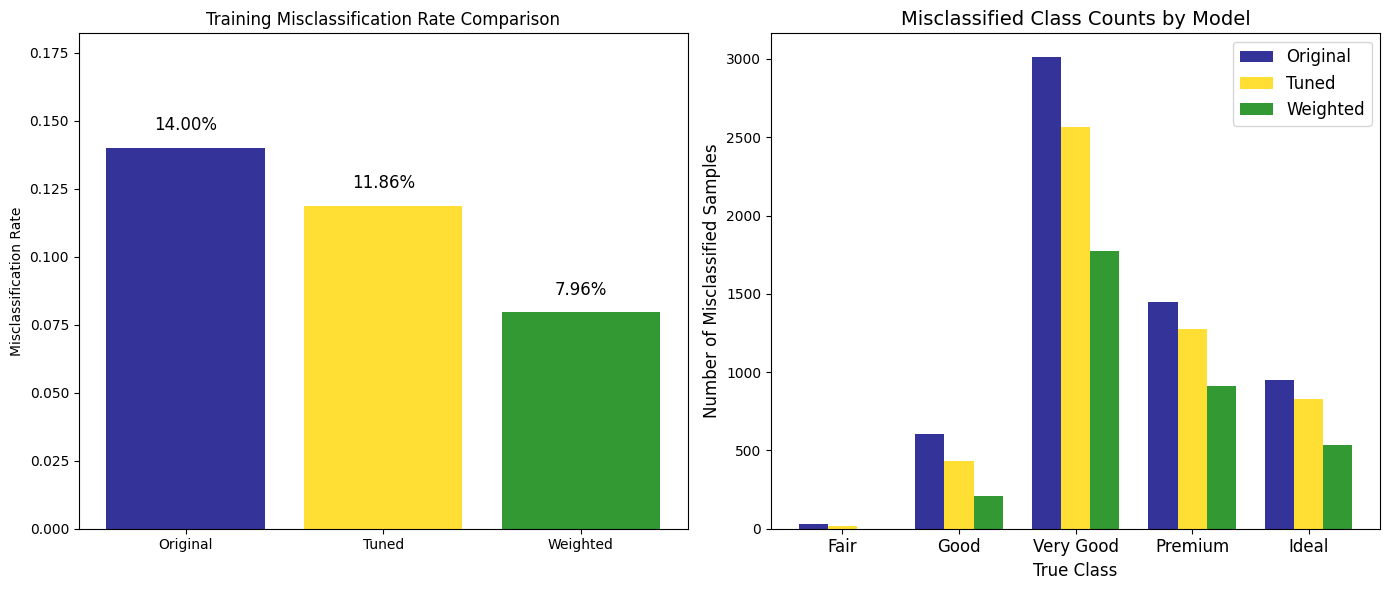

In [ ]:
plt.figure(figsize=(14,6))

# Training Misclassification Rate Comparison
plt.subplot(1,2,1)
bars = plt.bar(model_labels, rates, color=['navy', 'gold', 'green'], alpha=0.8)
plt.ylim(0, max(rates)*1.3)
plt.ylabel('Misclassification Rate')
plt.title('Training Misclassification Rate Comparison')

for bar in bars:
    height = bar.get_height()
    plt.text(
        bar.get_x() + bar.get_width()/2,
        height + 0.005,
        f"{height:.2%}",
        ha='center', va='bottom', fontsize=12
    )

# Misclassified Class Counts Comparison
plt.subplot(1,2,2)
x = np.arange(len(classes))  # positions for each class
width = 0.25  # width for each bar group

plt.bar(x - width,
        misclass_counts_original,
        width,
        label='Original',
        color='navy',
        alpha=0.8)
plt.bar(x,
        misclass_counts_tuned,
        width,
        label='Tuned',
        color='gold',
        alpha=0.8)
plt.bar(x + width,
        misclass_counts_weighted,
        width,
        label='Weighted',
        color='green',
        alpha=0.8)

plt.xticks(x, [cut_order[i] for i in classes], fontsize=12)
plt.xlabel('True Class', fontsize=12)
plt.ylabel('Number of Misclassified Samples', fontsize=12)
plt.title('Misclassified Class Counts by Model', fontsize=14)
plt.legend(fontsize=12)
plt.tight_layout()

plt.show()

# Model Ensembling

In [ ]:
from sklearn.ensemble import StackingClassifier, VotingClassifier

In [ ]:
weighted_xgb_pipeline = Pipeline([
    ('preprocessor', preprocessor),  # Gradient Boost
    ('xgb', weighted_xgb)            # Weighted XGBoost,
])

In [ ]:
stacking_clf = StackingClassifier(
    estimators=[
        ('gb', model4),
        ('xgb', weighted_xgb_pipeline)
    ],
    final_estimator=LogisticRegression(
        max_iter=1000,
        n_jobs=-1,
    ),
    n_jobs=-1,
    stack_method='predict_proba'
)

voting_clf = VotingClassifier(
    estimators=[
        ('gb_model', model4),
        ('weighted_xgb', weighted_xgb_pipeline)
    ],
    voting='soft'  # or 'hard', but soft is usually better for probabilities
)

In [ ]:
stacking_clf.fit(X_train, y_train)

StackingClassifier(estimators=[('gb',
                                Pipeline(steps=[('preprocessor',
                                                 Pipeline(steps=[('ct',
                                                                  ColumnTransformer(transformers=[('num',
                                                                                                   Pipeline(steps=[('imputer',
                                                                                                                    SimpleImputer(strategy='median'))]),
                                                                                                   ['carat',
                                                                                                    'depth',
                                                                                                    'table',
                                                                                                    'price',
                                                                                                    'x',
                                                                                                    'y',
                                                                                                    'z',
                                                                                                    'volume',
                                                                                                    'density']),
                                                                                                  ('cat',
                                                                                                   OneHotEncoder(handle_unknown='ignore'),
                                                                                                   ['color',
                                                                                                    'clarity'])])),
                                                                 ('inf_imputer',
                                                                  Simple...
                                                               max_bin=None,
                                                               max_cat_threshold=None,
                                                               max_cat_to_onehot=None,
                                                               max_delta_step=None,
                                                               max_depth=7,
                                                               max_leaves=None,
                                                               min_child_weight=1,
                                                               missing=nan,
                                                               monotone_constraints=None,
                                                               multi_strategy=None,
                                                               n_estimators=200,
                                                               n_jobs=None,
                                                               num_class=5,
                                                               num_parallel_tree=None, ...))]))],
                   final_estimator=LogisticRegression(max_iter=1000, n_jobs=-1),
                   n_jobs=-1, stack_method='predict_proba')

In [ ]:
voting_clf.fit(X_train, y_train)

[06:16:05] WARNING: /workspace/src/common/error_msg.cc:27: The tree method `gpu_hist` is deprecated since 2.0.0. To use GPU training, set the `device` parameter to CUDA instead.

    E.g. tree_method = "hist", device = "cuda"

[06:16:05] WARNING: /workspace/src/learner.cc:742: 
Parameters: { "predictor" } are not used.



VotingClassifier(estimators=[('gb_model',
                              Pipeline(steps=[('preprocessor',
                                               Pipeline(steps=[('ct',
                                                                ColumnTransformer(transformers=[('num',
                                                                                                 Pipeline(steps=[('imputer',
                                                                                                                  SimpleImputer(strategy='median'))]),
                                                                                                 ['carat',
                                                                                                  'depth',
                                                                                                  'table',
                                                                                                  'price',
                                                                                                  'x',
                                                                                                  'y',
                                                                                                  'z',
                                                                                                  'volume',
                                                                                                  'density']),
                                                                                                ('cat',
                                                                                                 OneHotEncoder(handle_unknown='ignore'),
                                                                                                 ['color',
                                                                                                  'clarity'])])),
                                                               ('inf_imputer',
                                                                Si...
                                                             grow_policy=None,
                                                             importance_type=None,
                                                             interaction_constraints=None,
                                                             learning_rate=0.2,
                                                             max_bin=None,
                                                             max_cat_threshold=None,
                                                             max_cat_to_onehot=None,
                                                             max_delta_step=None,
                                                             max_depth=7,
                                                             max_leaves=None,
                                                             min_child_weight=1,
                                                             missing=nan,
                                                             monotone_constraints=None,
                                                             multi_strategy=None,
                                                             n_estimators=200,
                                                             n_jobs=None,
                                                             num_class=5,
                                                             num_parallel_tree=None, ...))]))],
                 voting='soft')

In [ ]:
y_pred_stacking = stacking_clf.predict(X_test)
y_pred_voting = voting_clf.predict(X_test)

acc_stacking = accuracy_score(y_test, y_pred_stacking)
f1_stacking  = f1_score(y_test, y_pred_stacking, average='macro')
kappa_stacking = cohen_kappa_score(y_test, y_pred_stacking, weights='quadratic')

acc_voting = accuracy_score(y_test, y_pred_voting)
f1_voting  = f1_score(y_test, y_pred_voting, average='macro')
kappa_voting = cohen_kappa_score(y_test, y_pred_voting, weights='quadratic')

print("Stacking Ensemble Accuracy:", acc_stacking)
print("Stacking Ensemble Macro-F1:", f1_stacking)
print("Stacking Ensemble Cohen's Kappa:", kappa_stacking)

print("Voting Ensemble Accuracy:", acc_voting)
print("Voting Ensemble Macro-F1:", f1_voting)
print("Voting Ensemble Cohen's Kappa:", kappa_voting)


[06:16:08] WARNING: /workspace/src/common/error_msg.cc:27: The tree method `gpu_hist` is deprecated since 2.0.0. To use GPU training, set the `device` parameter to CUDA instead.

    E.g. tree_method = "hist", device = "cuda"

[06:16:08] WARNING: /workspace/src/common/error_msg.cc:27: The tree method `gpu_hist` is deprecated since 2.0.0. To use GPU training, set the `device` parameter to CUDA instead.

    E.g. tree_method = "hist", device = "cuda"



Stacking Ensemble Accuracy: 0.8152818991097923
Stacking Ensemble Macro-F1: 0.8104633617740331
Stacking Ensemble Cohen's Kappa: 0.8397005845742478
Voting Ensemble Accuracy: 0.8119436201780416
Voting Ensemble Macro-F1: 0.804431136565993
Voting Ensemble Cohen's Kappa: 0.8358353936768141


In [ ]:
stacking_ensemble_scores = [acc_stacking, f1_stacking, kappa_stacking]
voting_ensemble_scores = [acc_voting, f1_voting, kappa_voting]

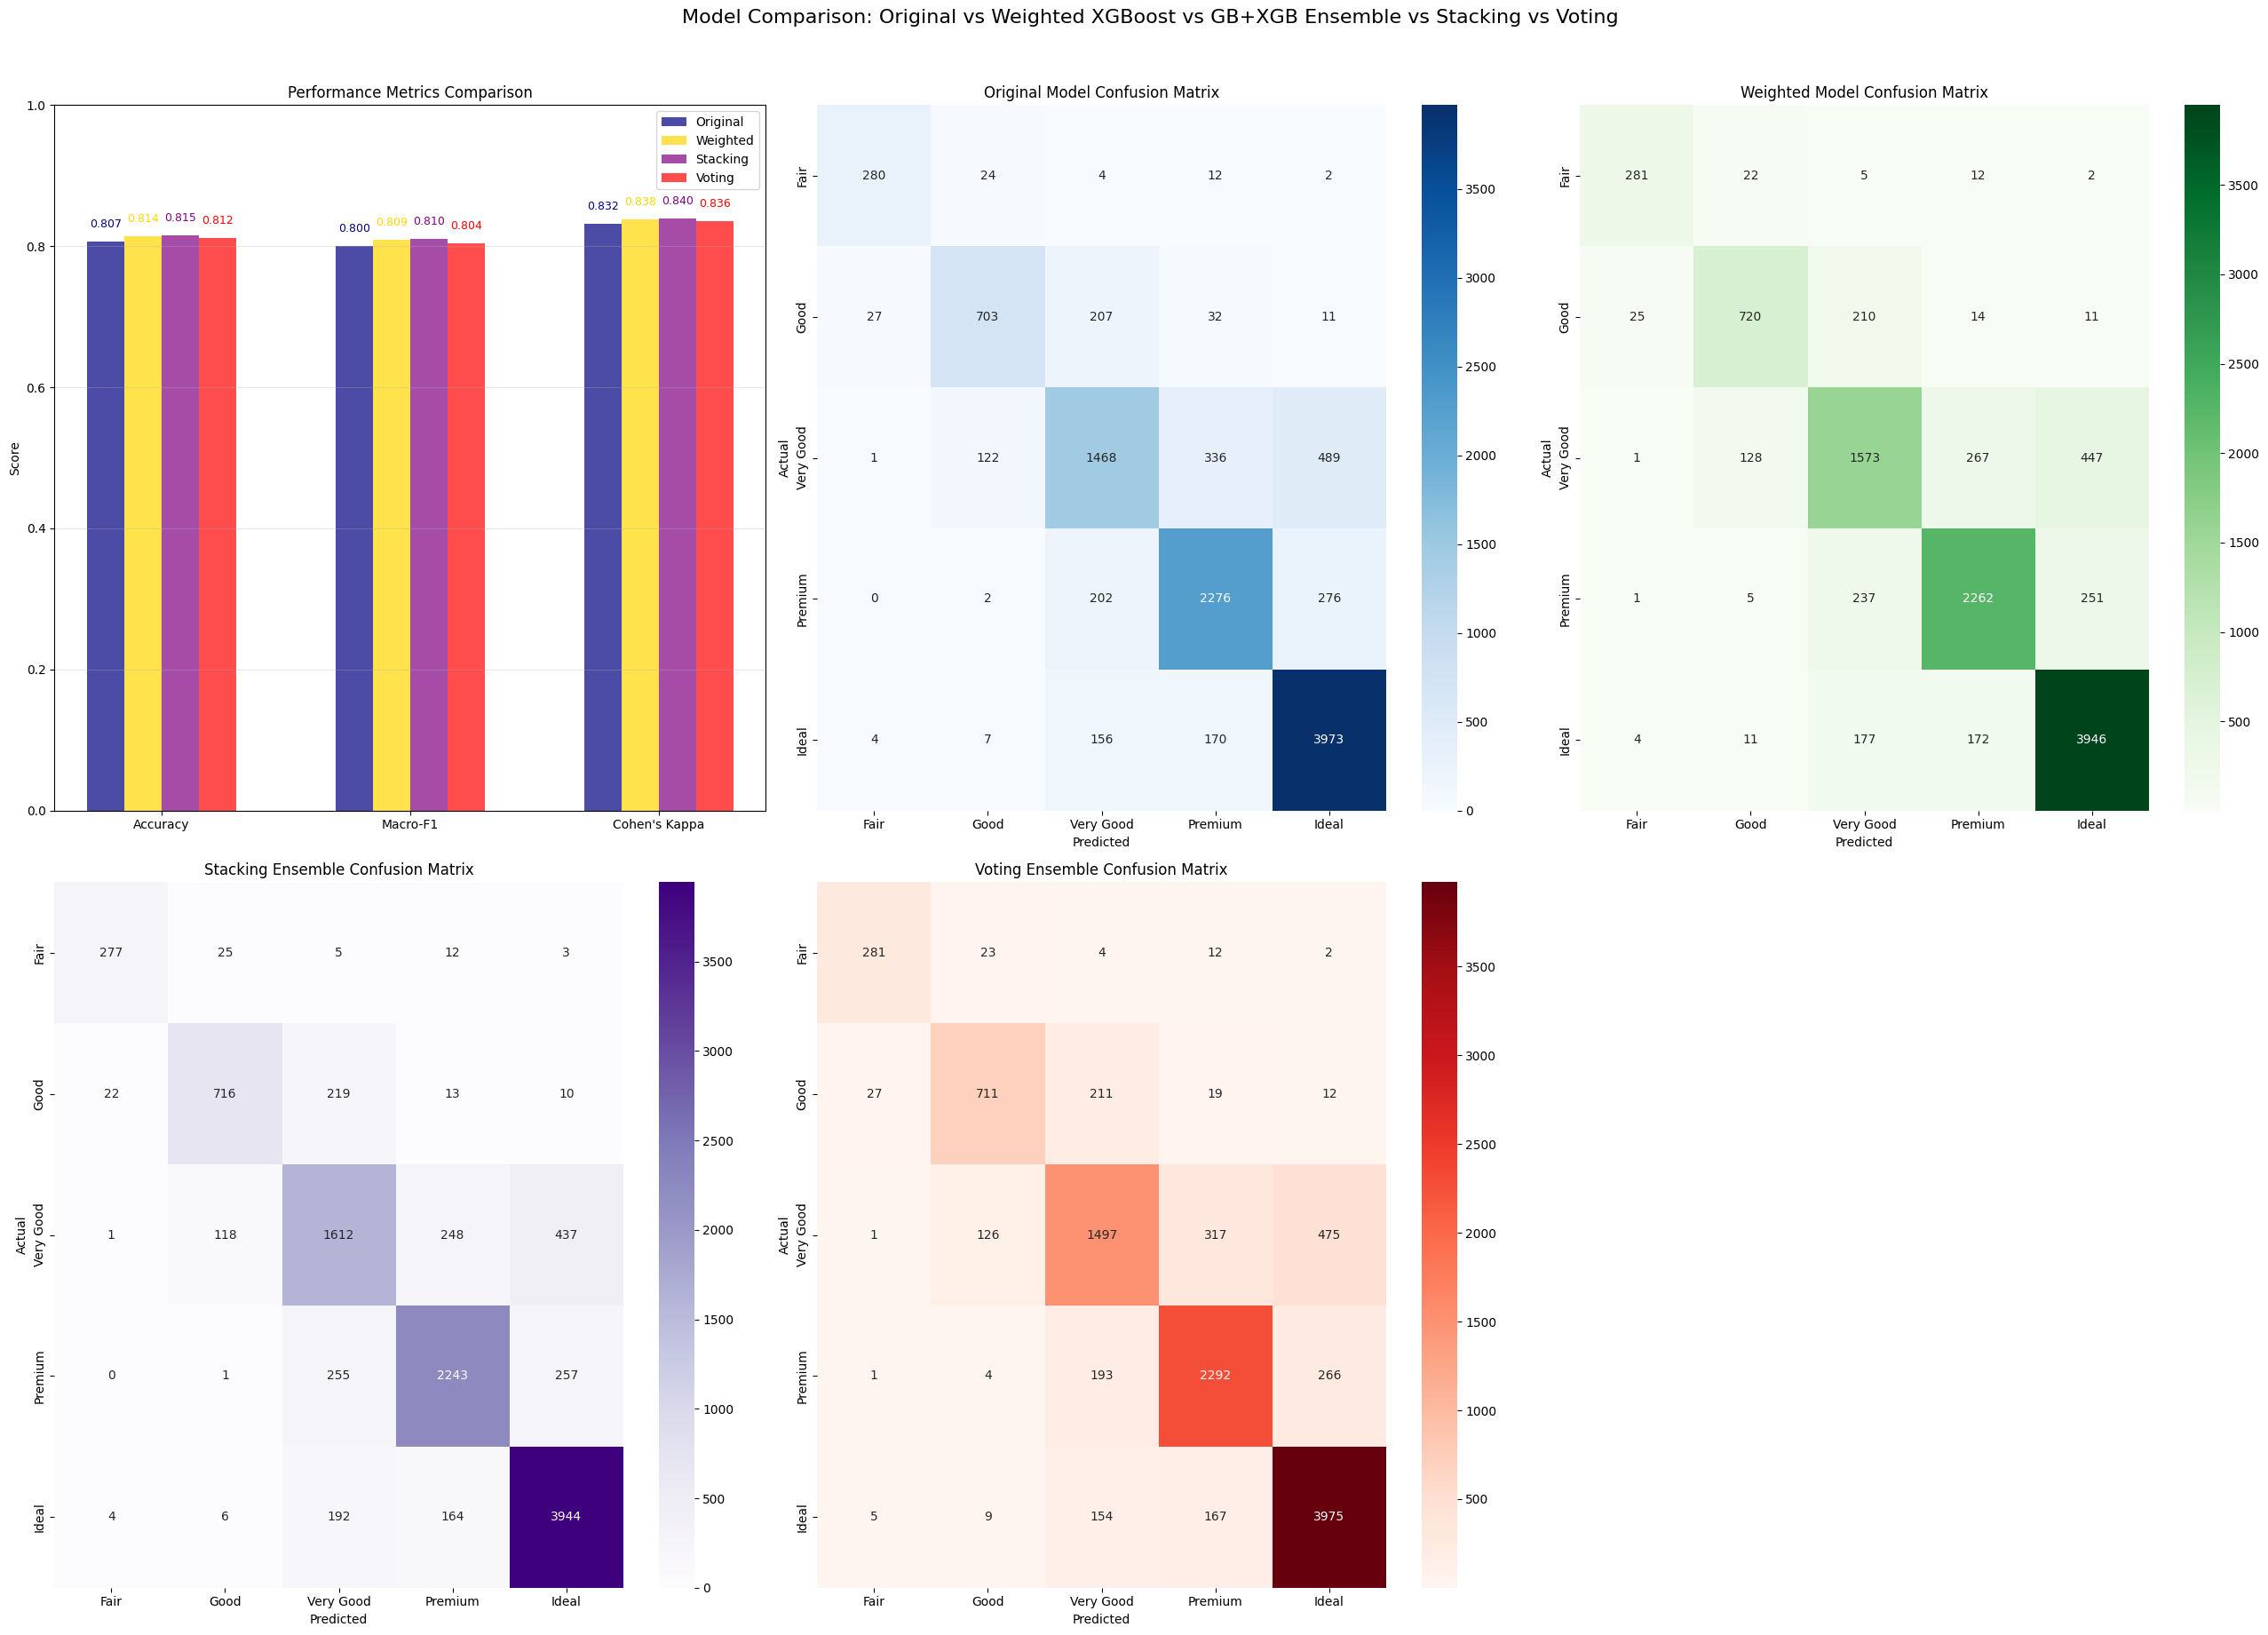

In [ ]:
# Confusion matrices for Stacking & Voting

metrics = ["Accuracy", "Macro-F1", "Cohen's Kappa"]

# Prepare the figure with 2 rows, 3 columns
plt.figure(figsize=(26, 18))
plt.suptitle("Model Comparison: Original vs Weighted XGBoost vs GB+XGB Ensemble vs Stacking vs Voting",
             y=1.02, fontsize=16)


plt.subplot(2, 3, 1)
x = np.arange(len(metrics))
width = 0.15

plt.bar(x - 1.5*width, original_scores,          width, label='Original', color='navy',        alpha=0.7)
plt.bar(x - 0.5*width,   weighted_scores,             width, label='Weighted',    color='gold',        alpha=0.7)
plt.bar(x + 0.5*width,   stacking_ensemble_scores, width, label='Stacking', color='purple',      alpha=0.7)
plt.bar(x + 1.5*width, voting_ensemble_scores,   width, label='Voting',   color='red',         alpha=0.7)

plt.xticks(x, metrics)
plt.ylabel('Score')
plt.ylim(0, 1)
plt.title('Performance Metrics Comparison')
plt.legend()
plt.grid(True, axis='y', alpha=0.3)

for i in range(len(metrics)):
    # Original
    plt.text(i - 1.5*width, original_scores[i] + 0.02,
             f'{original_scores[i]:.3f}', ha='center', color='navy', fontsize=9)
    # Tuned
    plt.text(i - 0.5*width, weighted_scores[i] + 0.02,
             f'{weighted_scores[i]:.3f}', ha='center', color='gold', fontsize=9)

    # Stacking
    plt.text(i + 0.5*width, stacking_ensemble_scores[i] + 0.02,
             f'{stacking_ensemble_scores[i]:.3f}', ha='center', color='purple', fontsize=9)
    # Voting
    plt.text(i + 1.5*width, voting_ensemble_scores[i] + 0.02,
             f'{voting_ensemble_scores[i]:.3f}', ha='center', color='red', fontsize=9)

# Original Model Confusion Matrix
plt.subplot(2, 3, 2)
cm_original = confusion_matrix(y_test, original_preds)
sns.heatmap(cm_original, annot=True, fmt='d', cmap='Blues',
            xticklabels=cut_order, yticklabels=cut_order)
plt.title('Original Model Confusion Matrix')
plt.xlabel('Predicted')
plt.ylabel('Actual')

# Weighted XGBoost Conf Matrix
plt.subplot(2, 3, 3)
cm_tuned = confusion_matrix(y_test, weighted_preds)
sns.heatmap(cm_tuned, annot=True, fmt='d', cmap='Greens',
            xticklabels=cut_order, yticklabels=cut_order)
plt.title('Weighted Model Confusion Matrix')
plt.xlabel('Predicted')
plt.ylabel('Actual')


# Stacking Ensemble Confusion Matrix
plt.subplot(2, 3, 4)
cm_stacking = confusion_matrix(y_test, y_pred_stacking)
sns.heatmap(cm_stacking, annot=True, fmt='d', cmap='Purples',
            xticklabels=cut_order, yticklabels=cut_order)
plt.title('Stacking Ensemble Confusion Matrix')
plt.xlabel('Predicted')
plt.ylabel('Actual')

# Voting Ensemble Confusion Matrix
plt.subplot(2, 3, 5)
cm_voting   = confusion_matrix(y_test, y_pred_voting)
sns.heatmap(cm_voting, annot=True, fmt='d', cmap='Reds',
            xticklabels=cut_order, yticklabels=cut_order)
plt.title('Voting Ensemble Confusion Matrix')
plt.xlabel('Predicted')
plt.ylabel('Actual')

plt.tight_layout()
plt.show()


# Comparing Confusion Scores For Everything

In [ ]:
# Original training predictions (using DMatrix for XGBoost model3)
dtrain = xgb.DMatrix(X_train_processed, label=y_train, feature_names=feature_names)
original_train_preds = np.argmax(model3.predict(dtrain), axis=1)

# Tuned training predictions (best_xgb is already tuned)
tuned_train_preds = best_xgb.predict(X_train_processed)

# Weighted training predictions (your weighted_xgb model)
weighted_train_preds = weighted_xgb.predict(X_train_processed)

# Get predictions from the ensemble models.
# (Note: your stacking and voting classifiers were trained on the raw X_train, so use that input)
stacking_train_preds = stacking_clf.predict(X_train)
voting_train_preds   = voting_clf.predict(X_train)

# Compute Training Misclassification Rates for each model
mis_err_original  = np.mean(original_train_preds != y_train)
mis_err_tuned     = np.mean(tuned_train_preds != y_train)
mis_err_weighted  = np.mean(weighted_train_preds != y_train)
mis_err_stacking = np.mean(stacking_train_preds != y_train)
mis_err_voting   = np.mean(voting_train_preds != y_train)

rates = [mis_err_original, mis_err_tuned, mis_err_weighted, mis_err_stacking, mis_err_voting]
model_labels = ['Original', 'Tuned', 'Weighted', 'Stacking', 'Voting']

# Compute Misclassified Class Counts for each model per class (classes are 0,1,2,3,4)
classes = np.unique(y_train)  # Typically, [0, 1, 2, 3, 4]

misclass_counts_original = [np.sum((y_train == cls) & (original_train_preds != cls)) for cls in classes]
misclass_counts_tuned    = [np.sum((y_train == cls) & (tuned_train_preds    != cls)) for cls in classes]
misclass_counts_weighted = [np.sum((y_train == cls) & (weighted_train_preds != cls)) for cls in classes]
misclass_counts_stacking = [np.sum((y_train == cls) & (stacking_train_preds != cls)) for cls in classes]
misclass_counts_voting   = [np.sum((y_train == cls) & (voting_train_preds   != cls)) for cls in classes]

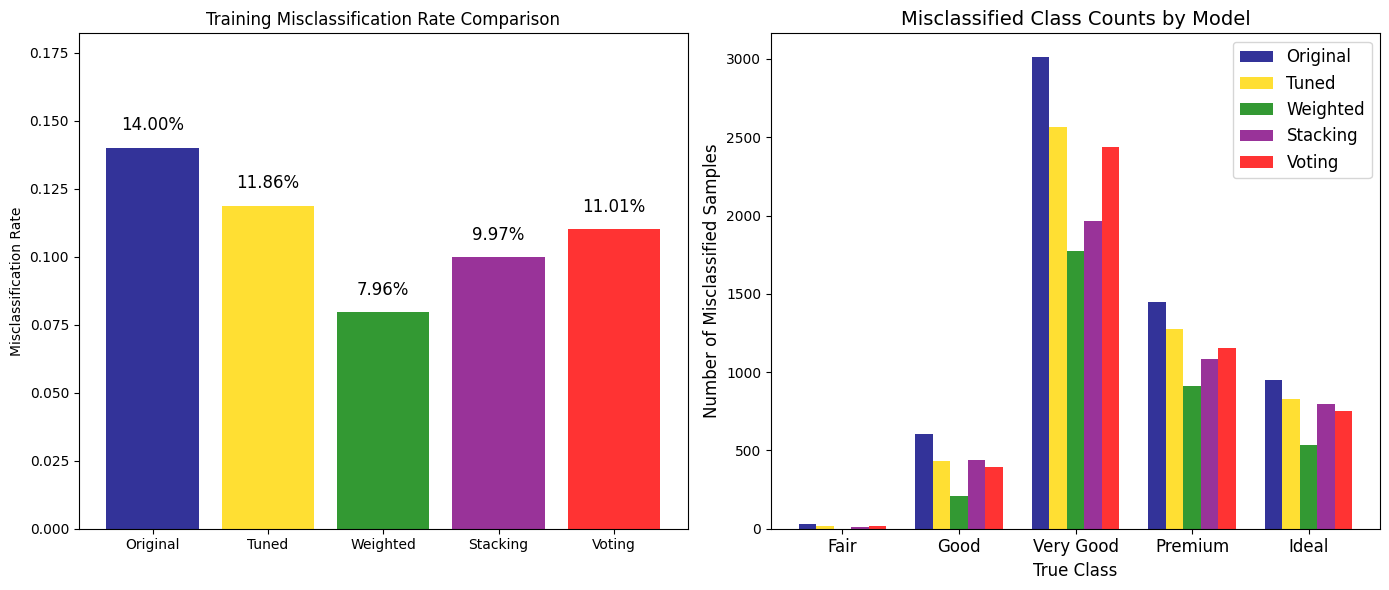

In [ ]:
plt.figure(figsize=(14,6))

# Subplot 1: Overall Training Misclassification Rate Comparison
plt.subplot(1,2,1)
bars = plt.bar(model_labels, rates, color=['navy', 'gold', 'green', 'purple', 'red'], alpha=0.8)
plt.ylim(0, max(rates)*1.3)
plt.ylabel('Misclassification Rate')
plt.title('Training Misclassification Rate Comparison')

for bar in bars:
    height = bar.get_height()
    plt.text(bar.get_x() + bar.get_width()/2, height + 0.005,
             f"{height:.2%}", ha='center', va='bottom', fontsize=12)

# Subplot 2: Misclassified Class Counts Comparison
plt.subplot(1,2,2)
x = np.arange(len(classes))  # positions for each class
width = 0.15  # width for each bar in a group (5 models → offsets: -2*width, -width, 0, width, 2*width)

plt.bar(x - 2*width, misclass_counts_original, width, label='Original', color='navy', alpha=0.8)
plt.bar(x - width,     misclass_counts_tuned,    width, label='Tuned',    color='gold', alpha=0.8)
plt.bar(x,             misclass_counts_weighted, width, label='Weighted', color='green', alpha=0.8)
plt.bar(x + width,     misclass_counts_stacking, width, label='Stacking', color='purple',alpha=0.8)
plt.bar(x + 2*width,   misclass_counts_voting,   width, label='Voting',   color='red', alpha=0.8)

plt.xticks(x, [cut_order[i] for i in classes], fontsize=12)  # use the original cut names
plt.xlabel('True Class', fontsize=12)
plt.ylabel('Number of Misclassified Samples', fontsize=12)
plt.title('Misclassified Class Counts by Model', fontsize=14)
plt.legend(fontsize=12)
plt.tight_layout()

plt.show()

# The Champion (Weighted XGB)

**7.98% Misclassification Rate | 81.4% Accuracy**

We did not chose Stacking as the best model because although it has 81.5% accuracy, it's misclassification rate is +2% higher than the Weighted XGB Model.

In [ ]:
finalTestData = pd.DataFrame({ # This is an ideal diamond from MichaelTrio.com
    'carat': [0.70],
    'color': ['D'],
    'clarity': ['VVS1'],
    'depth': [62.52],
    'table': [57],
    'price': [6122],
    'x': [5.66],
    'y': [5.62],
    'z': [3.52]
})

In [ ]:
finalTestData['volume'] = finalTestData['x'] * finalTestData['y'] * finalTestData['z']
finalTestData['density'] = finalTestData['carat'] / (finalTestData['volume'] + 1e-6)

In [ ]:
diamondCuts = ['Fair', 'Good', 'Very Good', 'Premium', 'Ideal']
finalTestData_processed = preprocessor.transform(finalTestData).astype(np.float32)
weighted_final_preds = weighted_xgb.predict(finalTestData_processed)
print("Weighted XGBoost:", [cut_order[p] for p in weighted_final_preds])

Weighted XGBoost: ['Ideal']


# Saving The Champion

In [ ]:
import joblib

In [ ]:
joblib.dump(weighted_xgb, 'DiamondCutClassifier v1-6.pkl')

['DiamondCutClassifier v1-6.pkl']